In [100]:
import numpy as np
import pandas as pd
from copy import deepcopy
from tslearn.clustering import TimeSeriesKMeans
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import math
import calendar
from pyproj import Transformer
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot, seasonal_plot
%matplotlib inline

In [370]:
# helper functions
def tkeo_operator(data, k = 1):
    npnts = len(data[0])
    nsignals = len(data)
    filt_data = deepcopy(data)
    for i in range(nsignals):
        for n in range(k, npnts-k):
            filt_data[i][n] = data[i][n]**2-data[i][n-1]*data[i][n+1]
    return filt_data

def standard_scaler(data):
    nsignals = len(data)
    for i in range(nsignals):
    #normalize to avoid spikes/plateaus during dtw due to differences in amplitudes
        normed_sig = (data[i]- np.mean(data[i]))/np.std(data[i])
        data[i] = normed_sig
    return data

def tsne_visualization(dtw_dists, centroids, data_labels):
    model = TSNE(learning_rate = 20, perplexity = 3)
    nsignals = len(dtw_dists)
    #fit model
    transformed = model.fit_transform(np.concatenate([dtw_dists, centroids]))

    xs = transformed[:,0]
    ys = transformed[:,1]

    for i in range(4):
        indices = np.where(data_labels == i)

        if i == 0:
            plt.scatter(xs[indices],ys[indices], marker = 'o')
        if i == 1:
            plt.scatter(xs[indices],ys[indices], marker = '^')
        if i == 2:
            plt.scatter(xs[indices],ys[indices], marker = 's')

    plt.scatter(xs[nsignals:],ys[nsignals:], marker = 'p', label = 'centroids')

    plt.title('TSNE of DTW correlation matrix')
    plt.legend()
    plt.show()

def pruned_dtw(matched, warped, window_size):
    #create distance matrix
    N = len(matched)
    M = len(warped)
    ###
    ub_coordinate_list, fraction, ub_partials = upper_bound_partials(matched, warped)
    ###
    #initialize auxiliary pruning variables
    start_column = 1
    end_column = 1

    #window must be greater than N-M
    window_size = np.max([window_size, N-M])

    #create cost matrix
    cost_matrix = np.ndarray((N+1, M+1))

    #initialize to infinity
    cost_matrix[:] = np.inf

    cost_matrix[0,0] = 0
    ###
    UB = ub_partials[1]
    ###
    #create traceback matrix
    traceback_matrix = np.ones((N,M))*np.inf

    #initialize window elements to zero
    for i in range(1,N+1):

        if N>=M:
            ub_col_index = int(np.floor(i*fraction))

        else:
            ub_col_index = int(np.floor(i/fraction))


        beg = np.max([start_column,ub_col_index-window_size])
        end = np.min([M+1, ub_col_index+window_size+1])
        smaller_found = False
        end_column_next = ub_col_index

        for j in range(beg, end):
            cost = np.abs(matched[i-1]-warped[j-1])

            penalty = [cost_matrix[i-1,j-1],  #match 0
                       cost_matrix[i-1,j], # insertion 1
                       cost_matrix[i, j-1]] # deletion 2
            penalty_index = np.argmin(penalty)
            traceback_matrix[i-1,j-1] = penalty_index
            cost_matrix[i,j] = cost +penalty[penalty_index]

            ###
            #if i == ub_col_index and i != N:
            if (i,j) in ub_coordinate_list:
                ub_index = ub_coordinate_list.index((i,j))
                UB = cost_matrix[i,j] + ub_partials[ub_index]
            ###

            ##pruning algorithm
            if cost_matrix[i,j] > UB:
                if smaller_found == False:
                    start_column = j+1

                if j >= end_column:
                    break

            else:
                smaller_found = True
                end_column_next = j+1
        end_column = end_column_next
    #traceback from bottom right corner

    i = N-1
    j = M-1

    path = [(i, j)]

    while i>0 and j>0:

        tb_type = traceback_matrix[i,j]

        if tb_type == 0:
            #match
            i = i-1
            j= j-1

        elif tb_type == 1:
            #insertion
            i = i-1
        else:
            #deletion
            j = j-1

        path.append((i,j))

    #strip infinite row and column from cost matrix
    cost_matrix = cost_matrix[1:, 1:]

    distance = cost_matrix[-1,-1]
    #invert path
    path= path[::-1]

    return cost_matrix, path, distance

def upper_bound_partials(signal1, signal2):
    signal_list = [signal1, signal2]
    coordinate_list = [[],[]]
    signal_lengths = [len(x) for x in signal_list]

    if signal_lengths[0]!= signal_lengths[1]:
        index_long = np.argmax(signal_lengths)
        index_short = np.argmin(signal_lengths)
        long_len = len(signal_list[index_long])
        short_len = len(signal_list[index_short])
        fraction = short_len/long_len
        long_index_list = [i for i in range(long_len)]
        short_index_list = [int(np.floor(x*fraction)) for x in range(long_len)]
        warped_short = np.take(signal_list[index_short], short_index_list)
        ub_partials = np.abs(signal_list[index_long]-warped_short)[::-1]
        coordinate_list[index_long] = long_index_list
        coordinate_list[index_short] = short_index_list

    else:
        ub_partials = np.abs(signal_list[0]-signal_list[1])[::-1]
        fraction = 1
        index_list1 = [i for i in range(signal_lengths[0])]
        index_list2 = [i for i in range(signal_lengths[1])]
        coordinate_list[0] = index_list1
        coordinate_list[1] = index_list2

    ub_partials = np.cumsum(ub_partials)[::-1]
    coordinate_list = zip(coordinate_list[0],coordinate_list[1])
    return list(coordinate_list), fraction, ub_partials

def warped_signal(path, warp_index, signal1):

    """the path array is an array of tuples of length 2 pairing indices from the two signals
    the warped index is the either 0 or 1 depending on which signal is desired to be warped. The
    values from the tuple correspond to the time indices of the warped signal
    """
    #create the warped_index and time_index arrays
    if warp_index == 0:

        warp_index = np.array(path)[:,0]
        time_index = np.array(path)[:,1]

    else:
        warp_index = np.array(path)[:,1]
        time_index = np.array(path)[:,0]

    #unique values of from the time_index array
    unique_time_index = np.unique(time_index)

    #instantiate warped_signal array
    warped_signal = np.zeros(len(unique_time_index))

    #create the time vector for the warped signal
    #time = time[unique_time_index]
    i =0

    #take the mean of warped signal values which share the same time_index
    for val in np.nditer(unique_time_index):
        indices = np.where(time_index == val)
        warped_signal[i] = np.mean(signal1[warp_index[tuple(indices)]])
        i += 1

    return unique_time_index, warped_signal

def dtw_correlation(data, window_size):
    nsignals = len(data)
    dtw_corrs = np.zeros([nsignals,nsignals])
    for i in range(nsignals):

        signal1 = data[i]
        for j in range(nsignals):
            signal2 = data[j]

            if i == j:
                dtw_corrs[i,j] = 1

            if dtw_corrs[i,j] == 0:
                cost_matrix, path, distance = pruned_dtw(signal1, signal2, window_size)

                #correlation between warped signal i and signal j
                index_w, warped_s = warped_signal(path, 0, signal1)
                corr = np.corrcoef(warped_s, signal2[(index_w)])[0,1]
                dtw_corrs[i,j] = corr

                #correlation between signal i and warped signal j
                index_w, warped_s = warped_signal(path, 1, signal2)
                corr = np.corrcoef(warped_s, signal1[(index_w)])[0,1]
                dtw_corrs[j,i] = corr

    return dtw_corrs

def representative_signal_indexes(clusters, dtw_dists):
    #find optimal ingroup representative of cluster
    unique_cluster_labels = np.unique(clusters)

    best_signals_indxs = np.zeros([len(unique_cluster_labels)], dtype = int)
    cluster_indxs_list = []
    i=0

    for label in unique_cluster_labels:

        cluster_indxs = np.where(clusters ==label)[0]
        cluster_indxs_list.append(cluster_indxs)
        ingroup_corrs = dtw_dists[:, cluster_indxs]
        ingroup_corrs = ingroup_corrs[cluster_indxs,:]

        #columnwise averages
        averages = np.mean(ingroup_corrs, axis = 0)
        idx = np.argmax(averages)
        best_signal = cluster_indxs[idx]
        best_signals_indxs[i] = best_signal
        i = i+1

    return cluster_indxs_list, best_signals_indxs

def dtw_average(signals, average_signal, iterations, window_size):
    nsignals = len(signals)
    paths = []
    match_indices = []
    signal_indices =[]

    for j in range(iterations):

        for n in range(nsignals):
            #perform dtw between signals and average
            paths.append(pruned_dtw(average_signal, signals[n], window_size)[1])

            #extract paired template indexes
            match_indices.append(np.array(paths[n])[:,0])

            #extract the paired signal indexes
            signal_indices.append(np.array(paths[n])[:,1])

        #length of template
        n_average = len(average_signal)

        #initialize array to store the new average signal
        average_signal = []
        time_index = []

        #iterate through indices of the template signal
        for i in range(n_average):

            for n in range(nsignals):

                #check to see if the template index i was paired with indexes of signaln
                if i in match_indices[n]:


                    #if so find indexes of pairs which contain the template index
                    indices = np.where(match_indices[n] == i)


                    #check to see if signal_values exists
                    if 'signal_values' in locals():

                        #if so find the paired signal2 indices, extract signal values and concat to signal_values
                        signal_values = np.concatenate((signal_values,signals[n][signal_indices[n][tuple(indices)]]))

                    else:
                        #if not find the paired signal2 indices, extract signal values
                        signal_values = signals[n][signal_indices[n][tuple(indices)]]

            #if signal_values exists take the mean and update average_signal[i]
            if 'signal_values' in locals():
                average_signal.append(np.mean(signal_values))
                del signal_values
                #save index value for time vector
                time_index.append(i)
        #convert lists to numpy arrays
        average_signal = np.array(average_signal)
        time_index = np.array(time_index)

    return time_index, average_signal

def average_incluster_signals(filt_data, clusters, dtw_dists, time_index_):
    cluster_indxs_list, best_signals_indxs = representative_signal_indexes(clusters, dtw_dists)
    iterations = 10
    window_size = 8
    average_signal_list = []
    time_index_list = []
    for j in range(len(cluster_indxs_list)):

        best_sig_indx = best_signals_indxs[j]
        group_indexes = cluster_indxs_list[j]
        average_signal = filt_data[best_sig_indx]
        signals_list = [filt_data[i] for i in group_indexes]

        time_index, average_signal = dtw_average(signals_list, average_signal, iterations, window_size)
        average_signal_list.append(average_signal)
        time_index_list.append(time_index_)
    return time_index_list, average_signal_list

In [429]:
df = pd.read_csv(f'C:/Users/YC/PycharmProjects/nitrateAnalysis/intermediate_data/stations_for_clustering.csv')

In [430]:
df['Date'] = pd.to_datetime(df['Date'])

In [431]:
# transform df to numpy array
stations = df['Objektnummer'].unique()
ndarray_cols = int(len(stations))
ndarray_rows = int(len(df.index)/len(stations))
data = df['LinearInter'].values.reshape(ndarray_cols,ndarray_rows)
time = df['Date'].unique()
#time_years = df['Date'].dt.year.unique()

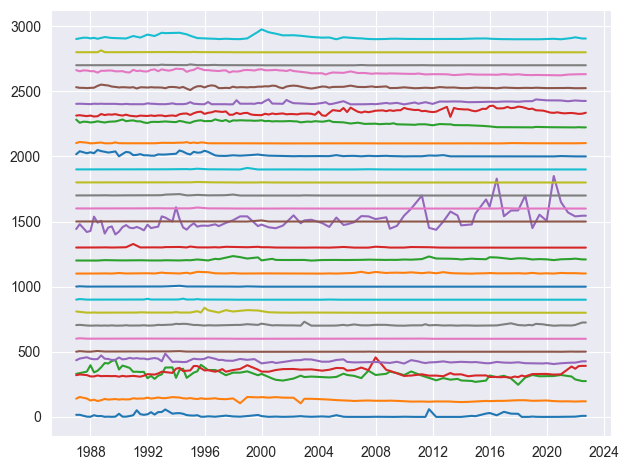

In [432]:
# plot unscaled data
nsignals = len(data)
for n in range(nsignals):
    plt.plot(time, data[n,:]+100*n)
plt.tight_layout()
plt.show()

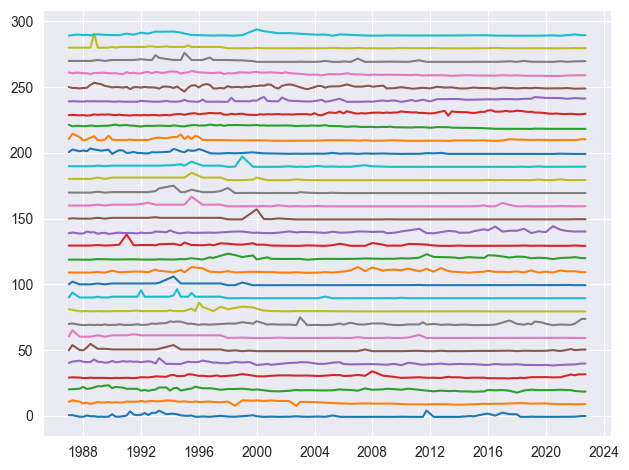

In [433]:
#standard scaler
filt_data = standard_scaler(data)
for n in range(nsignals):
    plt.plot(time, filt_data[n,:]+10*n)
plt.tight_layout()
plt.show()

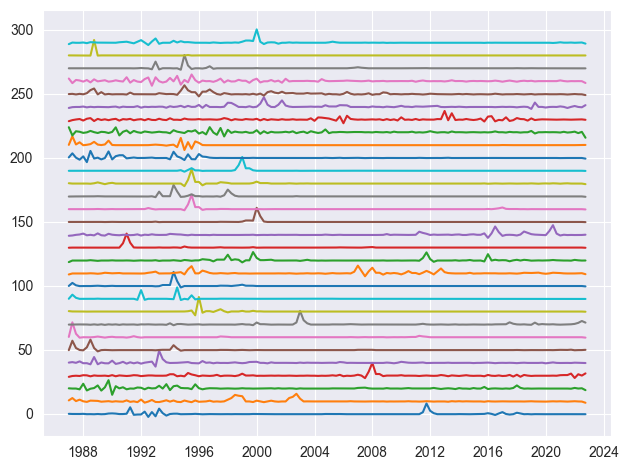

In [434]:
#tkeo operator
filt_data = tkeo_operator(data)

#standard scaler
filt_data = standard_scaler(filt_data)

for n in range(nsignals):
    plt.plot(time, filt_data[n,:]+10*n)
plt.tight_layout()
plt.show()

In [440]:
dtw_dists = dtw_correlation(data = filt_data, window_size = 2)

In [441]:
#kmeans clustering
kmeans_model = KMeans(n_clusters = 3)
clusters = kmeans_model.fit_predict(dtw_dists)

C:\Users\YC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


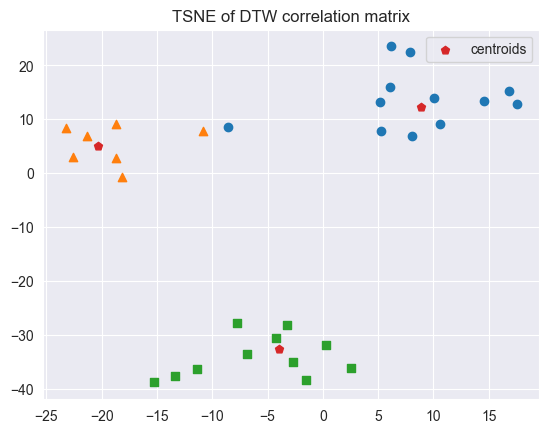

In [443]:

tsne_visualization(dtw_dists, kmeans_model.cluster_centers_, clusters)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


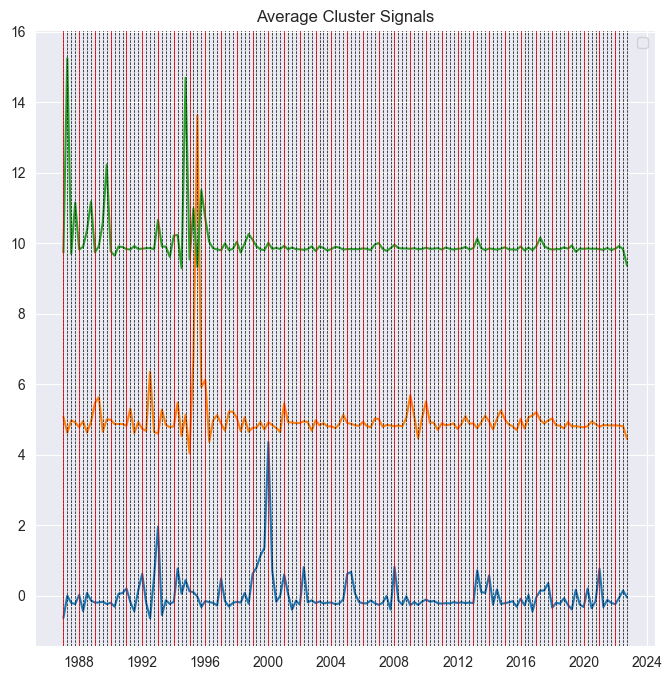

In [449]:
time_index_list, average_signal_list = average_incluster_signals(filt_data, clusters, dtw_dists, time)
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(average_signal_list)):
    ax.plot(time_index_list[i], average_signal_list[i]+5*i)
for xc in time_index_list[0]:
    ax.axvline(x=xc, color='black', linewidth=0.5, linestyle='--')
i = 0
for xy in time_index_list[0]:
    if i % 4 == 0:
        ax.axvline(x=xy, color='red', linewidth=0.5, linestyle='-')
    i = i + 1
ax.legend()
ax.set_title('Average Cluster Signals')
plt.show()

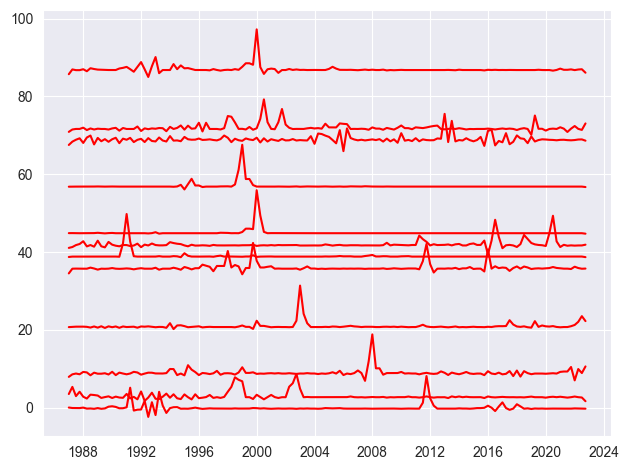

In [445]:
for n in range(nsignals):
    if clusters[n] == 0:
        plt.plot(time, filt_data[n,:]+3*n, color='red')
plt.tight_layout()
plt.show()

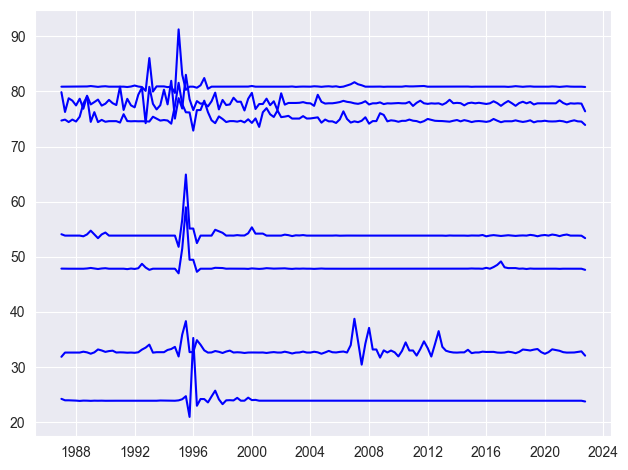

In [446]:
for n in range(nsignals):
    if clusters[n] == 1:
        plt.plot(time, filt_data[n,:]+3*n, color='blue')
plt.tight_layout()
plt.show()

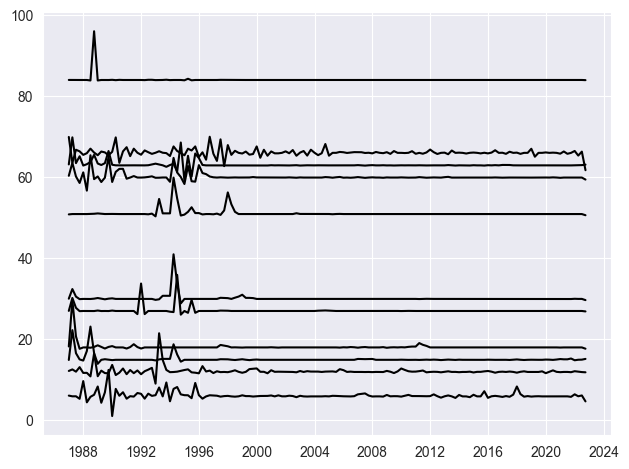

In [447]:
for n in range(nsignals):
    if clusters[n] == 2:
        plt.plot(time, filt_data[n,:]+3*n, color='black')
plt.tight_layout()
plt.show()

References: https://www.kaggle.com/code/aavigan/time-series-clustering-with-dynamic-time-warping/notebook,
https://colab.research.google.com/drive/1usNfL_8UUd15kz1oCeXlhz61CwcvOZxX?usp=sharing#scrollTo=bzDhAxXIxdqa,
Chatfield, C. The Analysis of Time Series: An Introduction, 5th ed. Boca Raton, FL: Chapman & Hall, 1996.
